In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

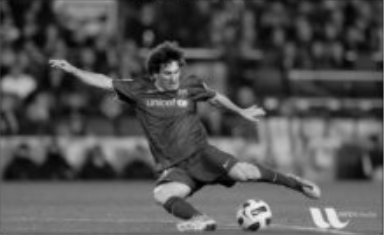

In [41]:
# open image
img = cv2.imread('messi.png', 1)
cv2_imshow(img)

In [4]:
def createPB(shape, center, radius, lpType=0, n=2):
    rows, cols = shape[:2]  # gets the number of rows and columns of the image
    r, c = np.mgrid[0:rows, 0:cols]  # creates a coordinate grid (same tip provided)
    c -= center[0]  # centers the coordinates around the provided center
    r -= center[1]  # centers the coordinates around the provided center
    d = np.sqrt(np.power(c, 2) + np.power(r, 2))  # calculates the Euclidean distance for each point (distance magnitude from the center)

    lpFilter_matrix = np.zeros(shape, np.float32)  # creates an empty matrix of type float32

    if lpType == 0:  # ideal low-pass filter
        lpFilter = np.copy(d)  # copies the distance matrix
        lpFilter[d <= radius] = 1  # keeps 1 inside the radius
        lpFilter[d > radius] = 0  # sets to 0 outside the radius

    elif lpType == 1:  # gaussian low-pass filter
        lpFilter = np.exp(-(d**2) / (2 * (radius**2)))  # gaussian filter formula

    lpFilter_matrix[:, :, 0] = lpFilter  # assigns the filter to the first channel
    lpFilter_matrix[:, :, 1] = lpFilter  # assigns the filter to the second channel

    return lpFilter_matrix  # returns the filter

In [5]:
def createPA(shape, center, radius, lpType=0, n=2):
    rows, cols = shape[:2]
    r, c = np.mgrid[0:rows, 0:cols]
    c -= center[0]
    r -= center[1]
    d = np.sqrt(np.power(c, 2) + np.power(r, 2))

    lpFilter_matrix = np.zeros(shape, np.float32)

    if lpType == 0:  # ideal high-pass filter
        lpFilter = np.copy(d)
        lpFilter[d <= radius] = 0
        lpFilter[d > radius] = 1

    elif lpType == 1:  # gaussian high-pass filter
        lpFilter = 1 - np.exp(-(d**2) / (2 * (radius**2)))

    lpFilter_matrix[:, :, 0] = lpFilter
    lpFilter_matrix[:, :, 1] = lpFilter

    return lpFilter_matrix

In [62]:
def apply_PA_PB_to_image(img_path, lpType=0, RETURN=1):
    img = cv2.imread(img_path, 0)
    image_f32 = np.float32(img)

    dft = cv2.dft(image_f32, flags=cv2.DFT_COMPLEX_OUTPUT)
    fft_shift = np.fft.fftshift(dft)

    # calc spec
    magnitude_spectrum = 20 * np.log(cv2.magnitude(fft_shift[:, :, 0], fft_shift[:, :, 1]))

    # normalization
    magnitude_spectrum -= magnitude_spectrum.min()
    magnitude_spectrum = (magnitude_spectrum / magnitude_spectrum.max()) * 255
    magnitude_spectrum = np.uint8(magnitude_spectrum)

    # get size
    nrows, ncols = fft_shift.shape[:2]
    real = np.power(fft_shift[:, :, 0], 2)
    imaginary = np.power(fft_shift[:, :, 1], 2)
    amplitude = np.sqrt(real + imaginary)

    minValue, maxValue, minLoc, maxLoc = cv2.minMaxLoc(amplitude)

    # create masks
    if lpType == 0:
      maskPA = createPA(fft_shift.shape, center=maxLoc, radius=35, lpType=0, n=2)
      maskPB = createPB(fft_shift.shape, center=maxLoc, radius=35, lpType=0, n=2)
    elif lpType == 1:
      maskPA = createPA(fft_shift.shape, center=maxLoc, radius=35, lpType=1, n=2)
      maskPB = createPB(fft_shift.shape, center=maxLoc, radius=35, lpType=1, n=2)
    else:
      print('invalid lpType')
      return -1

    # 1
    filtered_freq = fft_shift * maskPA
    # 2
    filtered_freqB = fft_shift * maskPB

    # set inv
    f_ishift = np.fft.ifftshift(filtered_freq)
    img_back = cv2.idft(f_ishift)
    img_back = cv2.magnitude(img_back[:, :, 0], img_back[:, :, 1])

    # set inv 2
    f_ishiftB = np.fft.ifftshift(filtered_freqB)
    img_backB = cv2.idft(f_ishiftB)
    img_backB = cv2.magnitude(img_backB[:, :, 0], img_backB[:, :, 1])

    # norm for print
    img_back -= img_back.min()
    img_back = (img_back / img_back.max()) * 255
    img_back = np.uint8(img_back)

    # norm for print B
    img_backB -= img_backB.min()
    img_backB = (img_backB / img_backB.max()) * 255
    img_backB = np.uint8(img_backB)

    # :)
    img_high = img_back
    img_low = img_backB

    # show and return
    if RETURN == 0:
      cv2_imshow(img_high)
      return img_high
    elif RETURN == 1:
      cv2_imshow(img_low)
      return img_low
    else:
      return -1

In [7]:
def create_gauss(sigma, size_x, size_y):
    x, y = np.meshgrid(np.linspace(-1, 1, size_x), np.linspace(-1, 1, size_y))
    calc = 1 / (2 * np.pi * (sigma ** 2))
    exp = np.exp(-(((x ** 2) + (y ** 2)) / (2 * (sigma ** 2))))

    kernel = exp * calc

    kernel = kernel / np.sum(kernel) # normalize the kernel so that the sum of the elements is 1

    return kernel

In [75]:
def apply_gauss(img_path):
    img = cv2.imread(img_path, 0)
    if img is None:
        print("Error: img not found")
    else:
        gaussian_kernel = create_gauss(sigma=1.5, size_x=5, size_y=5) # adjust sigma and sizes as needed

        img_filtered = cv2.filter2D(img, -1, gaussian_kernel) # apply the Gaussian filter

        # show
        cv2_imshow(img_filtered)
        return img_filtered

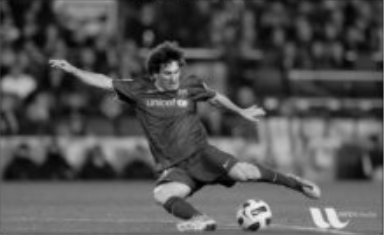

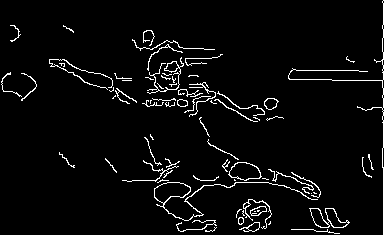

In [31]:
img = cv2.imread('messi.png')
assert img is not None, "file could not be read, check with os.path.exists()"
edges = cv2.messi(img, 100, 200)

# show
cv2_imshow(img)
cv2_imshow(edges)

In [20]:
def conv2d(img, kernel, padding=True):
    k_height, k_width = kernel.shape
    img_height, img_width = img.shape[:2]  # first two dimensions

    # calculate the necessary padding (if enabled)
    pad_height = k_height // 2
    pad_width = k_width // 2

    # create a padded version of the image to handle edges
    if padding:
        padded_img = np.pad(img, ((pad_height, pad_height), (pad_width, pad_width)), mode='constant', constant_values=0)
    else:
        padded_img = img

    output = np.zeros((img_height, img_width), dtype=float) # initialize the output image with zeros

    # perform manual convolution
    for i_img in range(img_height):
        for j_img in range(img_width):
            # apply the kernel to the region of the image
            for i_kernel in range(k_height):
                for j_kernel in range(k_width):
                    output[i_img, j_img] += padded_img[i_img + i_kernel, j_img + j_kernel] * kernel[i_kernel, j_kernel]

    return output

In [21]:
sobel_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])  # sobel horizontal
sobel_y = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])  # sobel vertical

def apply_sobel_filter(img):
    if len(img.shape) == 3:
        img = np.mean(img, axis=2)  # conversion to grayscale

    # apply convolution with the Sobel filter
    edges_x = conv2d(img, sobel_x)
    edges_y = conv2d(img, sobel_y)

    # Combine horizontal and vertical edges to get the total edge magnitude
    sobel_magnitude = np.sqrt(edges_x**2 + edges_y**2)

    return sobel_magnitude

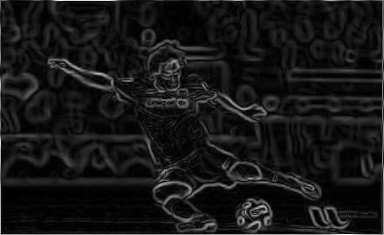

In [27]:
def show_sobel_filtered_image(sobel_img):
    sobel_img = np.uint8(255 * (sobel_img / np.max(sobel_img))) # convert to uint8

    cv2_imshow(sobel_img) # show

img_sobel_filtered = apply_sobel_filter(img) # apply
show_sobel_filtered_image(img_sobel_filtered) # show

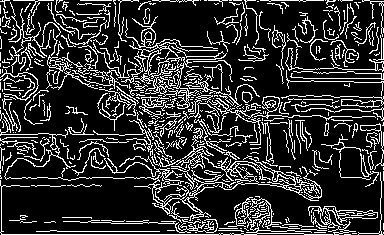

In [32]:
img_sobel_filtered = apply_sobel_filter(img) # apply

# convert img_sobel_filtered to uint8 before passing to Canny
img_sobel_filtered = np.uint8(img_sobel_filtered)

edges = cv2.Canny(img_sobel_filtered, 100, 200)

# show
cv2_imshow(edges)

high-pass filter


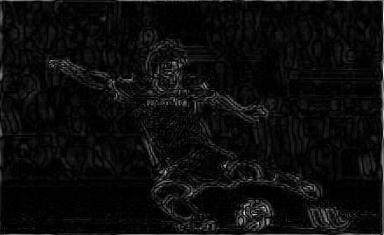

canny


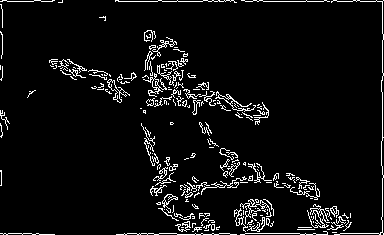

In [37]:
def apply_PA_with_canny():
    img = cv2.imread('messi.png', 0)
    image_f32 = np.float32(img)

    dft = cv2.dft(image_f32, flags=cv2.DFT_COMPLEX_OUTPUT)
    fft_shift = np.fft.fftshift(dft)

    # calc spec
    magnitude_spectrum = 20 * np.log(cv2.magnitude(fft_shift[:, :, 0], fft_shift[:, :, 1]))

    # normalization
    magnitude_spectrum -= magnitude_spectrum.min()
    magnitude_spectrum = (magnitude_spectrum / magnitude_spectrum.max()) * 255
    magnitude_spectrum = np.uint8(magnitude_spectrum)

    # get size
    nrows, ncols = fft_shift.shape[:2]
    real = np.power(fft_shift[:, :, 0], 2)
    imaginary = np.power(fft_shift[:, :, 1], 2)
    amplitude = np.sqrt(real + imaginary)

    minValue, maxValue, minLoc, maxLoc = cv2.minMaxLoc(amplitude)

    # create masks
    maskPA = createPA(fft_shift.shape, center=maxLoc, radius=35, lpType=1, n=2)

    # 1
    filtered_freq = fft_shift * maskPA

    # set inv
    f_ishift = np.fft.ifftshift(filtered_freq)
    img_back = cv2.idft(f_ishift)
    img_back = cv2.magnitude(img_back[:, :, 0], img_back[:, :, 1])

    # norm for print
    img_back -= img_back.min()
    img_back = (img_back / img_back.max()) * 255
    img_back = np.uint8(img_back)

    # show
    print('high-pass filter')
    cv2_imshow(img_back)

    # img_sobel_filtered = np.uint8(img_sobel_filtered)
    edges = cv2.messi(img_back, 100, 200)

    # show
    print('canny edge detection')
    cv2_imshow(edges)

apply_PA_with_canny()

In [67]:
def calculate_mse(img1, img2):  # mse
    return np.mean((img1.astype(float) - img2.astype(float)) ** 2)

def calculate_psnr(img1, img2):  # psnr
    mse = calculate_mse(img1, img2)
    if mse == 0:  # img == img
        return float('inf')
    max_pixel = 255.0
    return 20 * np.log10(max_pixel / np.sqrt(mse))

def calculate_rmse(img1, img2):  # rmse
    mse = calculate_mse(img1, img2)
    return np.sqrt(mse)  # return the square root of the MSE

gauss


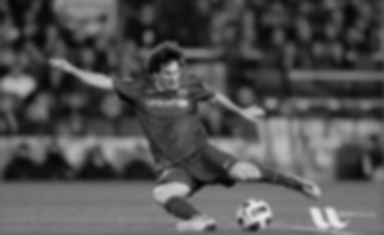

ideal low-pass


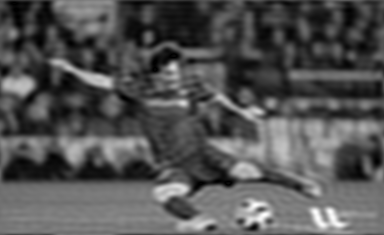

gaussian low-pass


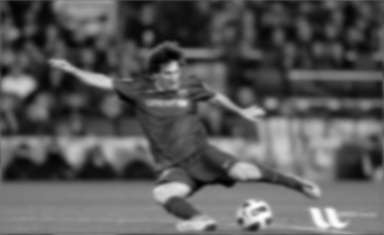

mse_gauss: 28.132967641843972
mse_low_pass: 43.70303634751773
mse_gaussian_low_pass: 80.82074468085106

psnr_gauss: 33.63864814180927
psnr_low_pass: 31.72568749454409
psnr_gaussian_low_pass: 29.05557513161498

rmse_gauss: 5.304052002181349
rmse_low_pass: 6.610827205994552
rmse_gaussian_low_pass: 8.990035855370715



In [82]:
img_original = cv2.imread('messi.png', 0)

print('gauss')
img_gauss = apply_gauss('messi.png') # apply gauss in img default

print('ideal low-pass')
img_low_pass = apply_PA_PB_to_image('messi.png', 0, 1) # apply low-pass filter in img default

print('gaussian low-pass')
img_gaussian_low_pass = apply_PA_PB_to_image('messi.png', 1, 1) # apply gaussian low-pass filter in img default

mse_gauss = calculate_mse(img_original, img_gauss)
mse_low_pass = calculate_mse(img_original, img_low_pass)
mse_gaussian_low_pass = calculate_mse(img_original, img_gaussian_low_pass)

psnr_gauss = calculate_psnr(img_original, img_gauss)
psnr_low_pass = calculate_psnr(img_original, img_low_pass)
psnr_gaussian_low_pass = calculate_psnr(img_original, img_gaussian_low_pass)

rmse_gauss = calculate_rmse(img_original, img_gauss)
rmse_low_pass = calculate_rmse(img_original, img_low_pass)
rmse_gaussian_low_pass = calculate_rmse(img_original, img_gaussian_low_pass)

print(f'mse_gauss: {mse_gauss}\nmse_low_pass: {mse_low_pass}\nmse_gaussian_low_pass: {mse_gaussian_low_pass}\n')
print(f'psnr_gauss: {psnr_gauss}\npsnr_low_pass: {psnr_low_pass}\npsnr_gaussian_low_pass: {psnr_gaussian_low_pass}\n')
print(f'rmse_gauss: {rmse_gauss}\nrmse_low_pass: {rmse_low_pass}\nrmse_gaussian_low_pass: {rmse_gaussian_low_pass}\n')

sobel


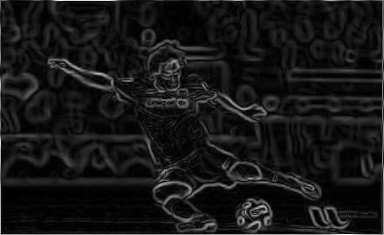

ideal high-pass


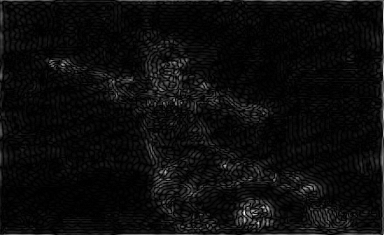

gaussian high-pass


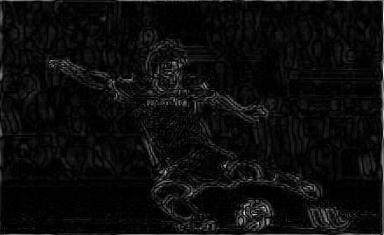

mse_sobel: 5763.965124827594
mse_high_pass: 6979.040070921986
mse_gaussian_high_pass: 7047.194215425532

psnr_sobel: 10.523590164394825
psnr_high_pass: 9.692846689855653
psnr_gaussian_high_pass: 9.650641203731492

rmse_sobel: 75.92078190342612
rmse_high_pass: 83.54064921295492
rmse_gaussian_high_pass: 83.94756825200794



In [86]:
img_original = cv2.imread('messi.png', 0)

print('sobel')
img_sobel = apply_sobel_filter(img_original) # apply sobel in img default
show_sobel_filtered_image(img_sobel)

print('ideal high-pass')
img_high_pass = apply_PA_PB_to_image('messi.png', 0, 0) # apply high-pass filter in img default

print('gaussian high-pass')
img_gaussian_high_pass = apply_PA_PB_to_image('messi.png', 1, 0) # apply gaussian high-pass filter in img default

mse_sobel = calculate_mse(img_original, img_sobel)
mse_high_pass = calculate_mse(img_original, img_high_pass)
mse_gaussian_high_pass = calculate_mse(img_original, img_gaussian_high_pass)

psnr_sobel = calculate_psnr(img_original, img_sobel)
psnr_high_pass = calculate_psnr(img_original, img_high_pass)
psnr_gaussian_high_pass = calculate_psnr(img_original, img_gaussian_high_pass)

rmse_sobel = calculate_rmse(img_original, img_sobel)
rmse_high_pass = calculate_rmse(img_original, img_high_pass)
rmse_gaussian_high_pass = calculate_rmse(img_original, img_gaussian_high_pass)

print(f'mse_sobel: {mse_sobel}\nmse_high_pass: {mse_high_pass}\nmse_gaussian_high_pass: {mse_gaussian_high_pass}\n')
print(f'psnr_sobel: {psnr_sobel}\npsnr_high_pass: {psnr_high_pass}\npsnr_gaussian_high_pass: {psnr_gaussian_high_pass}\n')
print(f'rmse_sobel: {rmse_sobel}\nrmse_high_pass: {rmse_high_pass}\nrmse_gaussian_high_pass: {rmse_gaussian_high_pass}\n')